# Assignment 1
## Getting started with SED fitting & error estimation


This assignment is split into 3 sections, roughly corresponding to the contents of each of the 3 weeks in the Error Estimation module. 

The SETUP section is designed to be done first, to familarize yourself with the data and the details of SED fitting. Section 1 is shorter to account for this. You should be able to finish Section 1 after January 26th, Section 2 after February 2nd, and Section 3 after February 9th. You can work on this assignment during the lab hours, as well as in your own time - and feel free to ask the instructors questions!

All assignments are presented as Jupyter notebooks. You will fork the repository to have your own access to all files. You can edit this notebook directly with your answers and push your changes to GitHub. Feel free to write any commonly used functions in a separate module and import them here if you like.

# Section 0
## Setup

First, we need to set up the SED fitting project, install Prospector, and make sure we can run Prospector.

1. Download the data from [here](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html) (both the input and output catalog). <br>
   The data comes from [Chang et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..219....8C/abstract), who used MAGPHYS (another SED fitting code) to fit the photometry stored in the input file and obtain stellar masses / ages / etc. stored in the output file. <br>
   > Be careful of where you store these files. If you store them in a random place in this repository, they will get pushed to Git alongside your changes. The files are heavy, which will cause problems downstream. We suggest placing your files in `projects/sed-fitting/data` folder (for Chang catalogs) and `projects/sed-fitting/output` folder (for your own Prospector output files). These folders are added in the `.gitignore` file in the root, and so anything in these folders will be ignored by Git.
   
2. Install [Prospector](https://github.com/bd-j/prospector)
   > We found this easiest to do using the [conda script](https://github.com/bd-j/prospector/blob/main/conda_install.sh) provided: download the script somewhere on your PC and run `bash conda_install.sh`. Again, best not to do this inside the Git repository as the bash script will download several large libraries. If you are feeling brave, you can try doing it from this repository, but first make sure to add the libraries to `.gitignore`. <br>
   > Make sure to follow the instructions from `conda_install.sh`: add SPS_HOME to your `~/.bashrc` file as your terminal says.<br>
   > This bash script will create a new conda environment, `prospector`, which you can run using `conda activate prospector`.
    <br><br>

3. Fix a Prospector + NumPy >= 1.20 issue (you might not need this)<br>
   Run the following cell:

In [28]:
import numpy as np
print(np.__version__)

1.26.3


If the version is greater than 1.20.0, you will need to fix a library in Prospector to make it compatible with a later NumPy. There is a file `write_results.py` in the project library. Copy it to your Prospector installation location within your conda environment, it should be something like `/home/[username]/[your conda installation]/envs/prospector/lib/[your python version]/site-packages/prospect/io`

4. Install any other Python libraries<br>Since we have made a new environment, it will only have prospector and its dependancies installed. We still need to install other useful Python libraries in the new environment. 
   > We listed the libraries you will need in `requirements.txt`.<br>
   > First, run `conda activate prospector` to make sure you are using the new environment. <br>
   > Then, you can install all required libraries simply using `pip install -r requirements.txt`


## Test Prospector

We have provided a notebook, Prospector Example, that gives step-by-step instructions for loading in the photometric data for one galaxy and running Prospector to get a simple fit to that galaxy's SED. If you have any questions, you can either ask us, or consult the [Prospector documentation](https://prospect.readthedocs.io/en/latest/) that has explanations of all the different parameters, models, and use cases.

#### Step 1
Open the example notebook and run it completely without changing anything. <br> (This is to make sure everything is installed right)

#### Step 2
Try to change some fitting parameters: you can try a different galaxy, play around with different priors, try a different star formation model, or a different sampling technique.

What did you try? What was different between the fits?


***Answer:*** I tried a different galaxy, ID=44 after trying ID=33. The fit for 44 with the basic model does not seem as good, particularly in the IR regime. This could be due to dust if it is a dusty galaxy. It would probably be good to try different dust models

#### Step 3
Try running Prospector through a command line.

Re-running a notebook each time is impractical, so to fit several galaxies, it's easier to write everything as a Python script we can run from the command line. We wrote a Python script for you, `assignment_params.py`. 

It has a few command line arguments. You can see the meaning of the different arguments by running

     python assignment_params.py --help

Try running this line in your command line to ensure that Prospector works fine and produce a fit for a test galaxy.

> Note: if you stored your data files elsewhere, you will need to change the path to the input catalog on Line 200.

#### Step 4

Here we load in the data, select one random set of parameters $\vec{\theta}$, and the optimized set of parameters $\vec{\theta}_{max}$. We also generate an SED from these two models, and a full spectroscopic model.

In [29]:
import prospect.io.read_results as reader
import matplotlib.pyplot as plt

Loading in data:

In [30]:
file_name = '/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/output/test_44_fixz_24Feb15-15.41_result.h5' #### Change this to your filename!
res, obs, model = reader.results_from(file_name)
results_type = "emcee" # | "dynesty"
sps = reader.get_sps(res)

Selecting a random and the best models:

In [31]:
# To draw a random chain
randint = np.random.randint

# Selecting a random (not best) parameter vector from MCMC
if results_type == "emcee":
    nwalkers, niter = 2, 2
    theta = res['chain'][randint(nwalkers), randint(niter)]
else:
    theta = res["chain"][randint(len(res["chain"]))]

# Index of the best chain / parameter vector
imax = np.argmax(res['lnprobability'])

# Selecting the best parameter vector
if results_type == "emcee":
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = res["chain"][imax, :]
    thin = 1

Getting x-values: the central wavelengths of our filters, and changing them to restframe

In [32]:
# cosmological redshifting
a = 1.0 + model.params.get('zred', 0.0) 

# photometric effective wavelengths
wphot = obs["phot_wave"]

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

# Find bounds 
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()*10

Create the SEDs for the random and the best fit models. The SED photometry is stored in `mspec` (first returned value) and the full spectrum is in `mphot` (second returned value).

In [34]:
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

Plot the fit and the model:

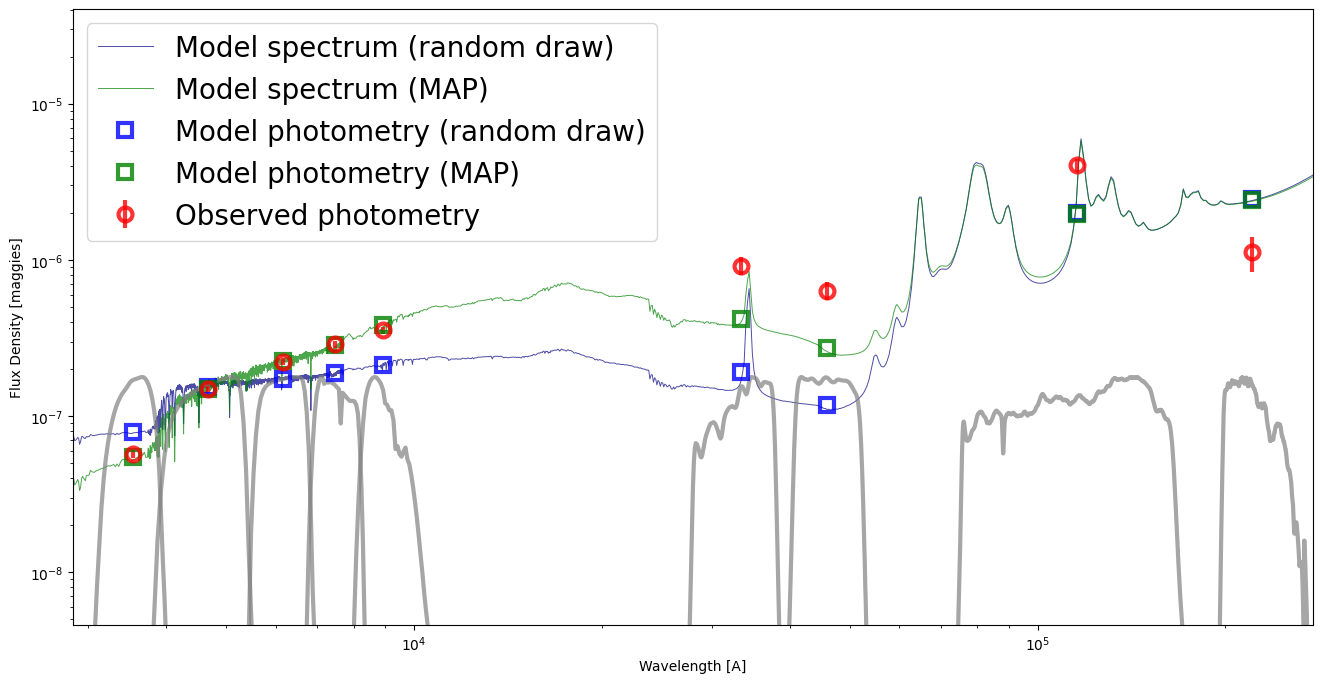

In [35]:
# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

# plt.ylim(1e-9, 1e-6)

> Note: if you want to make these plots several times for different galaxies / fits, it may be useful to save this code as a separate Python file, e.g. `plotting.py`. You can then import these functions in this notebook or elsewhere without re-defining them.

#### Step 5

The code below loads in the table containing the photometry of all galaxies as a [Pandas DataFrame](https://pandas.pydata.org/). Select a sample of galaxies to run Prospector on. 

***Answer:*** I'm using ID=44 as my galaxy for the rest of this assignment

In [36]:
from astropy.table import Table
from astropy.io import fits
with fits.open('/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()

df.head()

,id,ra,dec,redshift,PLATE,MJD,FIBERID,designation,flux0_u,flux0_u_e,...,flux_w2_e,flux_w3,flux_w3_e,flux_w4,flux_w4_e,extin_u,extin_g,extin_r,extin_i,extin_z
0,3,337.450310,1.266134,0.088372,376,52143,404,J222948.07+011558.1,0.000031,0.000003,...,0.000049,4.172000e-07,0.000209,0.000002,0.001187,0.341327,0.265960,0.183990,0.136724,0.101698
1,5,338.115522,1.270146,0.163800,376,52143,567,J223227.69+011612.6,0.000011,0.000004,...,0.000111,9.851000e-07,0.000493,0.000004,0.001883,0.368063,0.286793,0.198402,0.147434,0.109664
2,8,341.101481,1.266255,0.143369,378,52146,404,J224424.38+011558.3,0.000017,0.000003,...,0.000039,1.013700e-06,0.000507,0.000008,0.003856,0.337630,0.263079,0.181997,0.135243,0.100596
3,12,341.870909,1.267913,0.275242,378,52146,567,J224729.01+011604.3,0.000007,0.000003,...,0.000106,9.999000e+00,9.999000,0.000009,0.004526,0.358145,0.279064,0.193055,0.143461,0.106709
4,14,342.686706,1.270160,0.089104,676,52178,373,,0.000031,0.000003,...,9.999000,9.999000e+00,9.999000,9.999000,9.999000,0.362289,0.282293,0.195289,0.145121,0.107943


**Optional:** how did you choose your set of galaxies? It's okay if they are all random, but if you want, you can try to choose a sample you find interesting.

In [ ]:
# Space to select a sample of N galaxies, answer the question, or do something else. 
# If you are sampling randomly, you can use df.sample()!

Don't forget to save your sample or at least note down the id's you used!

#### Step 6

Run Prospector on your chosen sample. Feel free to use the default code we provided, or try your own fitting / modelling parameters.

> Hint: you can use Jupyter to run something from the command line using `!`. This allows you to pass variables from your Jupyter environment as arguments in curly braces `{...}`. For example, you could run:

    ! python assignment_params.py --objid={your_index} --optimize --emcee 

> If you are using Python without Jupyter, you can't use `!`, but you can use [subprocess.run()](https://docs.python.org/3/library/subprocess.html#subprocess.run) function.

#### Step 7

The photometry of the galaxy changes based on how far away it is: galaxies further away are fainter, and their SED shifts more towards red wavelengths. This is one of the challenges of SED fitting: it's hard to break the degeneracy between galaxies that are red because they are intrinsically red (older stars), and galaxies that are red because they are far away. 

By default, we give Prospector a *known* spectroscopic redshift for each galaxy. This means that it is not fitting one of the important degenarate parameters.

However, obtaining a spectroscopic redshift is difficult, as it requires measuring a galaxy spectrum - simple photometry is way easier. The galaxies we used in this project all have spectroscopy, but there are millions of galaxies that do not. For those objects, we need to fit the SED *and* redshift simultaneously.

Let's imagine that we don't know the redshift of our objects. For your sample, re-run the Prospector fits by setting redshift as one of the free parameters. You can change the redshift from fixed to free by using `--var-redshift` argument when calling `assignment_params.py`. 

In [ ]:
for idx, row in tqdm(sample.iterrows(), total=numsample):
    outname = f'gal{idx}_emcee_varz'
    ! python assignment_params.py --objid={idx} --optimize --emcee --outfile={outname} --var_redshift

# Section 1

#### Step 1: Goodness-of-Fit

Choose one of your galaxies, load in the data, and plot the original data and the best fit with error bars.

Compute the goodness-of-fit ($\chi^2$) of your fit. 

> Note: Prospector assumes the magnitudes are independent so you can to, but we'll come back to this later

In [57]:
file_name = '/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/output/test_44_fixz_24Feb15-15.41_result.h5' #### Change this to your filename!
res, obs, model = reader.results_from(file_name)
results_type = "emcee" # | "dynesty"
sps = reader.get_sps(res)



In [59]:

# Index of the best chain / parameter vector
imax = np.argmax(res['lnprobability'])

# Selecting the best parameter vector
if results_type == "emcee":
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = res["chain"][imax, :]
    thin = 1




In [60]:
# cosmological redshifting
a = 1.0 + model.params.get('zred', 0.0) 

# photometric effective wavelengths
wphot = obs["phot_wave"]

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

# Find bounds 
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()*10

In [61]:
# mspec_free, mphot_free, mextra_free = model_free.mean_model(theta_free, obs_free, sps=sps_free)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

In [41]:
all_theta = res['chain']

all_theta_flat = all_theta.reshape(all_theta.shape[0]*all_theta.shape[1], all_theta.shape[2])

phot_res = []
for i in range(len(all_theta_flat)):
    mspec_map_i, mphot_map_i, _ = model.mean_model(all_theta_flat[i], obs, sps=sps)
    phot_res.append(mphot_map_i)


In [42]:
fit_err_down = np.percentile(phot_res, 16, axis=0)
fit_err_up = np.percentile(phot_res, 84, axis=0)

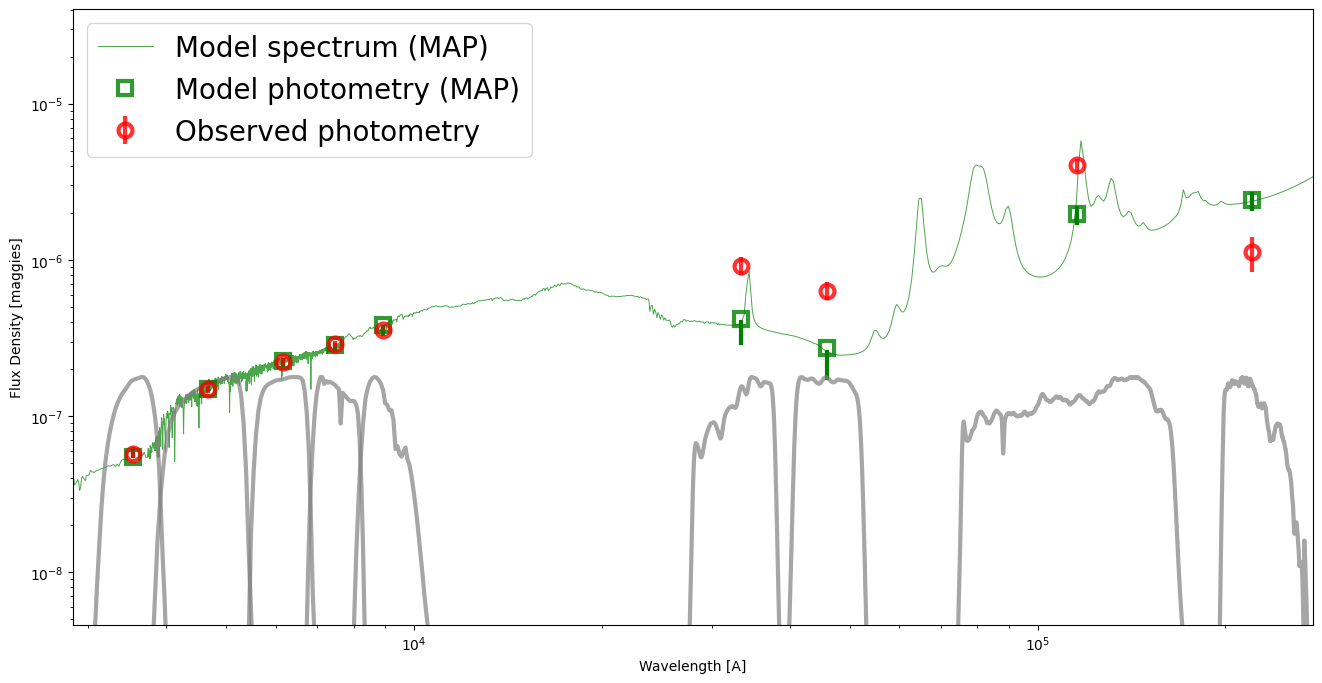

In [43]:
# Make plot of data and model
plt.figure(figsize=(16,8))

# plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
#        lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
# plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
#          marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
#          markerfacecolor='none', markeredgecolor='blue', 
#          markeredgewidth=3)



for i in range(len(wphot)):
    plt.plot([wphot[i], wphot[i]], [fit_err_down[i], fit_err_up[i]], linewidth=3, color='green')


plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

# plt.ylim(1e-9, 1e-6)

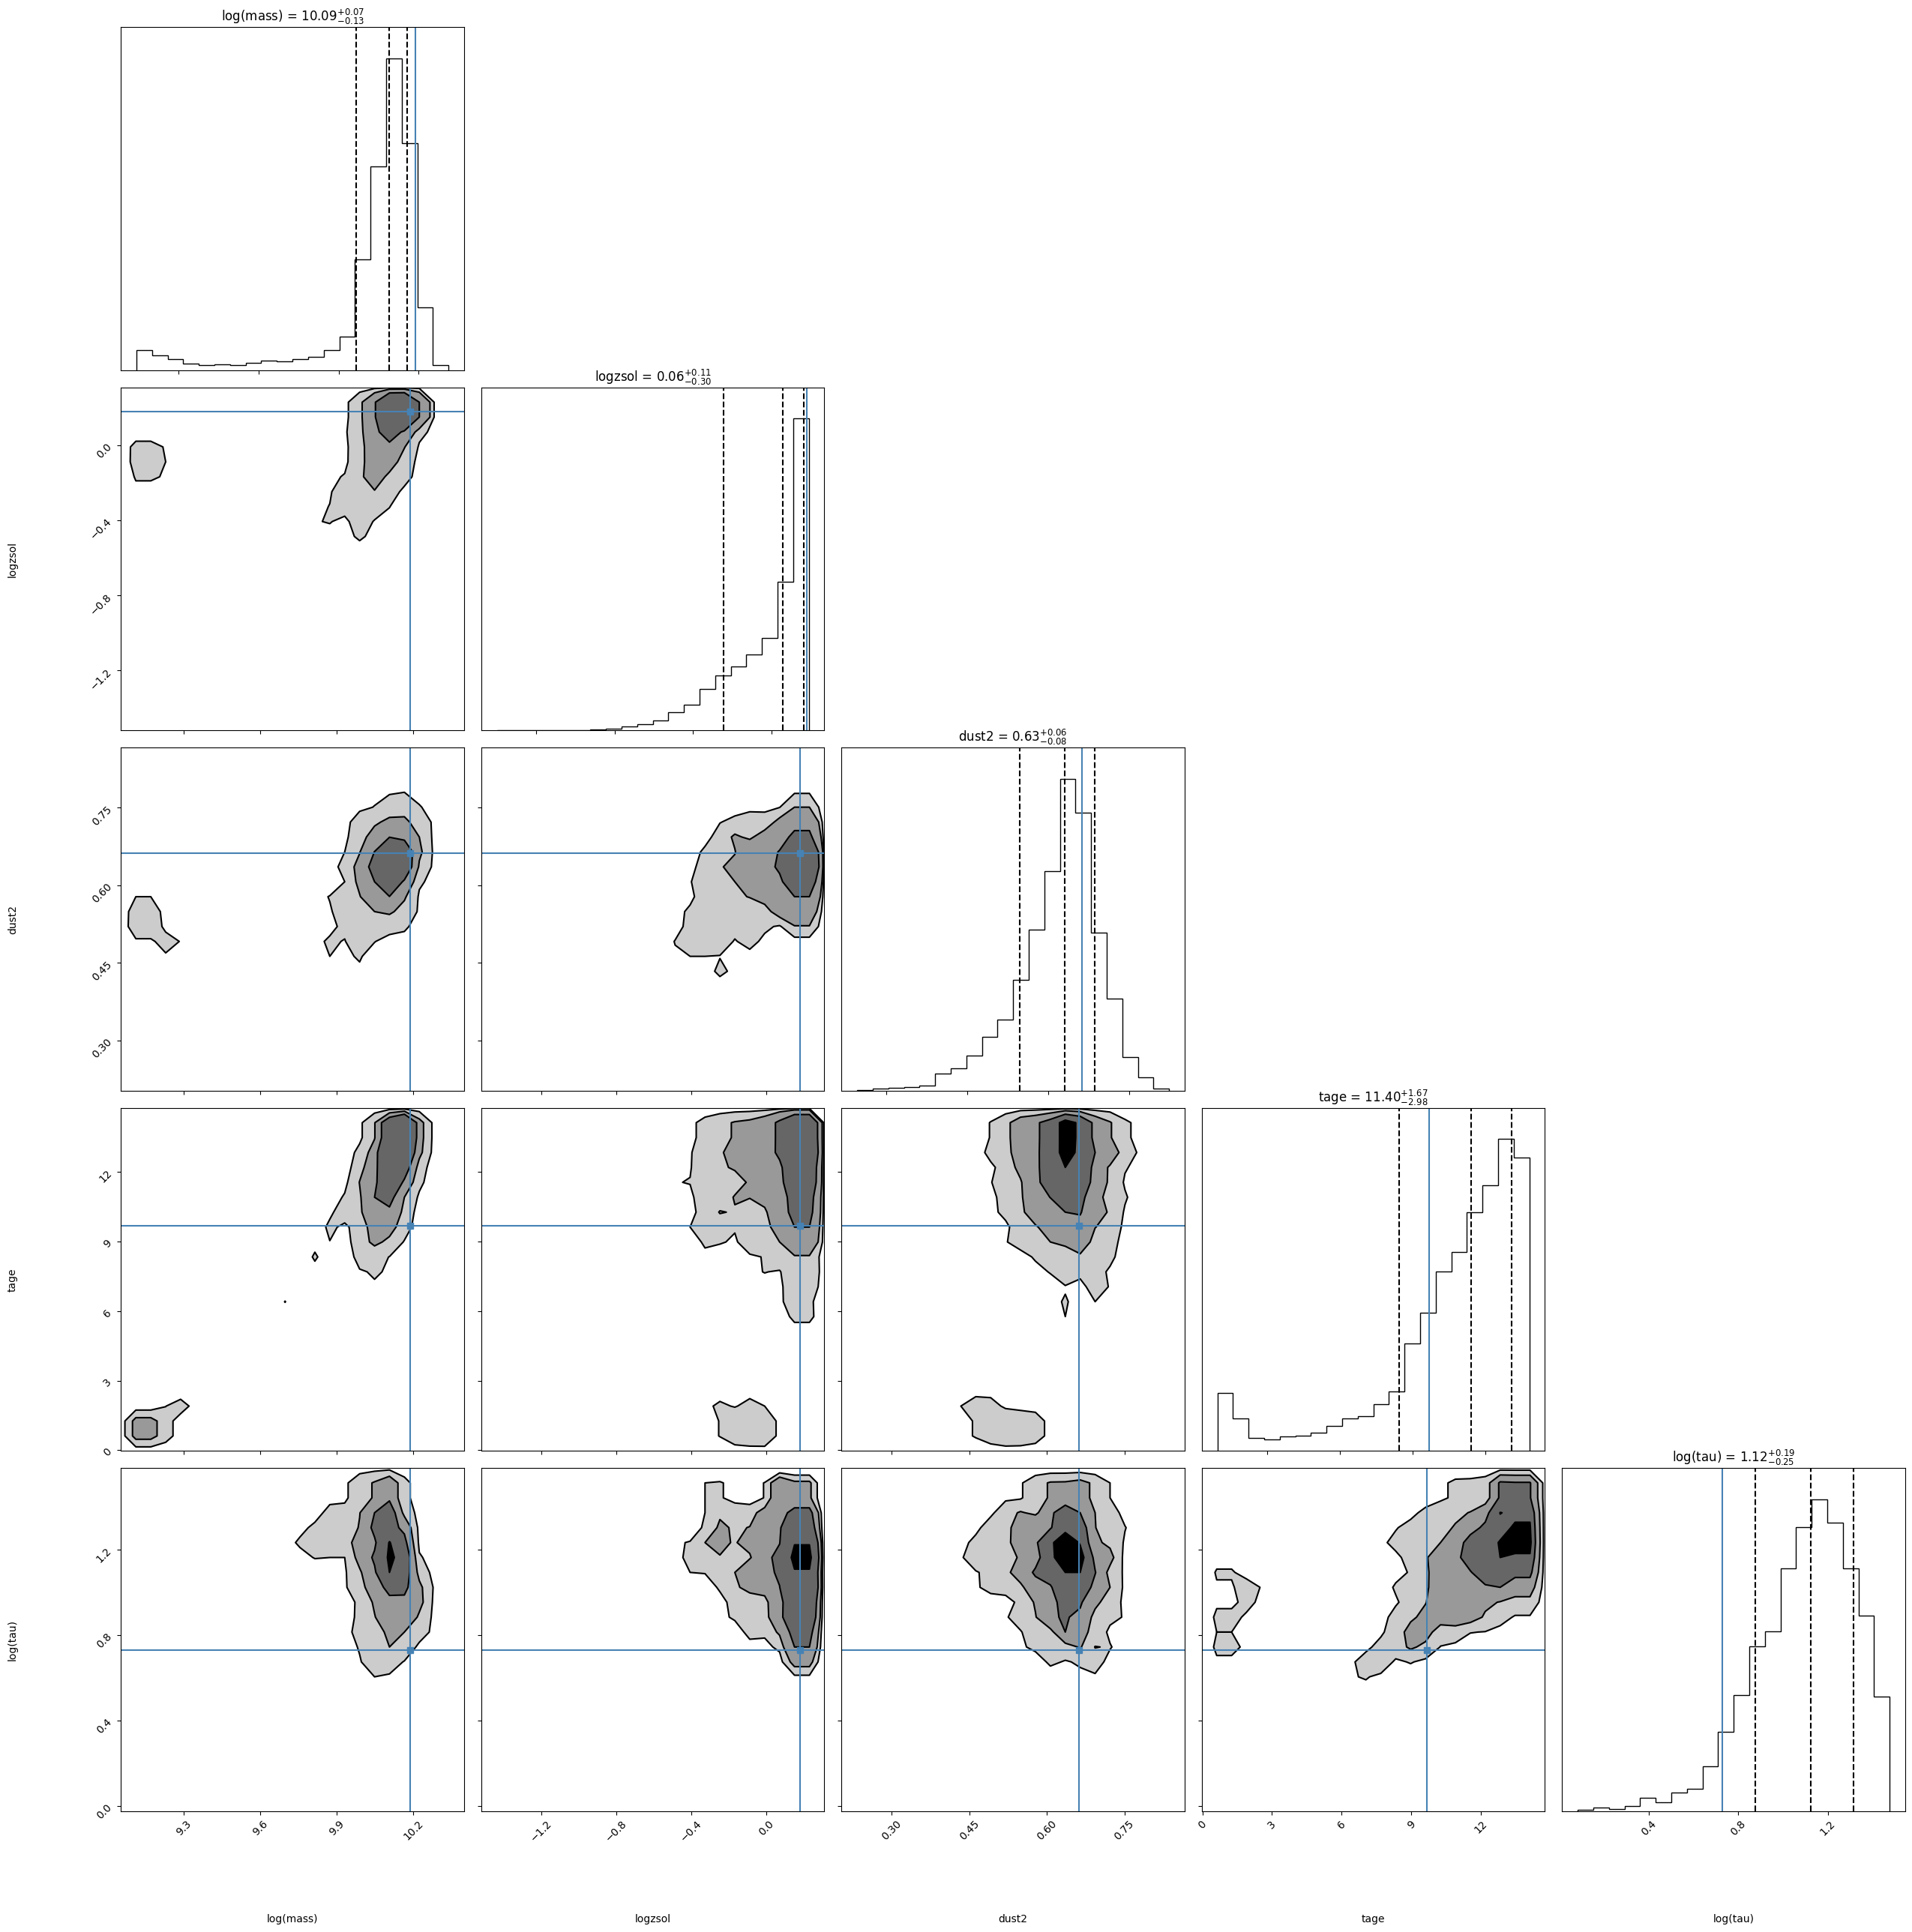

In [62]:
cornerfig = reader.subcorner(res, start=0, thin=thin, truths=theta_max, 
                             fig=plt.subplots(5,5,figsize=(27,27))[0])

In [90]:
def chisquare(obs, exp, sig):
    return np.sum((obs-exp)**2 / sig**2)

Xsq = chisquare(obs['maggies'], mphot_map, obs['maggies_unc'])

print(Xsq)


92.33301067985413


Is your goodness-of-fit reasonable? Why / why not?

 ***Answer:*** It's bad! If we have four degrees of freedom (9 data points minus 5 free params) then the reduced $\chi_{\nu}^2 \sim 23$, meanwhile a good $\chi_{\nu}^2$ should be 1. This value suggests that the model is not fully capturing a good fit of the data

#### Step 2: Fit results

What are the best fit, mean, and $1\sigma$, $2\sigma$, $3\sigma$ confidence intervals for each of the constrained parameters?

In [45]:
import pandas as pd

def get_CI(res):


    param_names = [x['name'] for x in res['model_params'] if x['isfree'] == True]

    param_bestfit = res['bestfit']['parameter']
    chains = res['chain']


    df_data = []
    for i in range(len(param_names)):
        chain = chains[:,:,i].flatten()
        mean = np.mean(chain)
        CI = np.percentile(chain, [0.15, 2.5, 16, 84, 97.5, 99.85])
        if param_names[i] == 'mass':
            d = [param_names[i], np.log10(param_bestfit[i]), np.log10(np.mean(chain))]
            d.extend(np.log10(CI).tolist())
            df_data.append(d)
        else:
            d = [param_names[i], param_bestfit[i], np.mean(chain)]
            d.extend(CI.tolist())
            df_data.append(d)
        
    return pd.DataFrame(df_data, columns=['param', 'best_fit', 'mean', '-3sig', '-2sig', '-1sig', '1sig', '2sig', '3sig'])


get_CI(res)


,param,best_fit,mean,-3sig,-2sig,-1sig,1sig,2sig,3sig
0,mass,10.186897,10.064927,9.155850,9.244085,9.967177,10.158120,10.226666,10.263354
1,logzsol,0.181573,-0.022785,-0.902131,-0.544983,-0.246348,0.164655,0.186206,0.189901
2,dust2,0.661517,0.618303,0.306347,0.436239,0.547720,0.686158,0.743562,0.789590
3,tage,9.676390,10.611803,1.056234,1.595996,8.476395,13.074941,13.690459,13.794013
4,tau,5.358900,13.992087,1.625780,3.921524,7.555521,20.759459,27.340980,29.846645


Are your results consistent with the fit from Chang et al.? (You can look up their values in the [output catalog](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html)). 

How similar do we expect them to be?

In [46]:

from astropy.table import Table

chang = Table.read("/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/data/sw_output.fits")
chang_in = Table.read("/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/data/sw_input.fits")

gal44 = chang[44]

chang_down = gal44['lmass16_all']
chang_up = gal44['lmass84_all']
chang_2down = gal44['lmass2_5_all']
chang_2up = gal44['lmass97_5_all']
print(chang_down, chang_up)

9.59 9.98


***Answer:*** My $1\sigma$ confidence interval for the stellar mass is 9.97 to 10.15, whereas the Chang et al. interval is 9.59 to 9.98. There is only a tiny bit of overlap between the two, and as much my result is not very consistent with the Chang values. I do not necessarily expect my values to be consistent as my fit is not very good, and I would imagine Chang et al. did a more thorough job testing different things like dust models and having meaningful priors, whereas I didn't do any of this

#### Step 3: Comparing samples

Check the probability distribution of a single parameter (e.g., stellar mass) for a single galaxy and compare to the result from Chang et al. How different do you expect them to be? what does this tell you about the models you and Chang et al are fitting? You can try for a few different galaxies if you like to see if your conclusions are the same

9.143058448110303


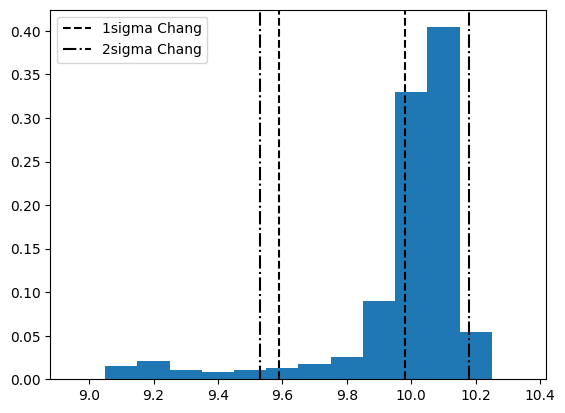

In [47]:

logmass = np.log10(all_theta_flat[:,0])
print(np.min(logmass))
bins = np.arange(9.0, 10.5, 0.1)
hist, bins = np.histogram(np.log10(all_theta_flat[:,0]), bins=bins)



plt.bar(bins[:-1], hist/len(logmass), width=0.1)
plt.axvline(chang_down, color='k', linestyle='--', label='1sigma Chang')
plt.axvline(chang_up, color='k', linestyle='--')
plt.axvline(chang_2down, color='k', linestyle='-.', label='2sigma Chang')
plt.axvline(chang_2up, color='k', linestyle='-.')
plt.legend()

***Answer:*** The peak of my probability distribution, which contains most of the galaxies, falls within the $2\sigma$ confidence interval from Chang et al. Again, given the rigour that was likely involved with the Chang work, I would not expect our distributions to necessarily be similar. I expect the Chang model may have a better dust model or something, considering the poor fit to the IR regime in my case. Additionally, I have used a very simple star formation history model, and a more complex one may produce a better fit.

#### Step 4: Redshift

How did allowing the redshift as a free parameter change the results? Did you get the same mass? Is the redshift correct?

In [93]:
file_name = '/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/output/test_44_freez_24Feb15-15.58_result.h5' #### Change this to your filename!
res, obs, model = reader.results_from(file_name)
results_type = "emcee" # | "dynesty"
sps = reader.get_sps(res)


# Index of the best chain / parameter vector
imax = np.argmax(res['lnprobability'])

# Selecting the best parameter vector
if results_type == "emcee":
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = res["chain"][imax, :]
    thin = 1


# cosmological redshifting
a = 1.0 + model.params.get('zred', 0.0) 

# photometric effective wavelengths
wphot = obs["phot_wave"]

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

# Find bounds 
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()*10


mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model

# plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
#          marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
#          markerfacecolor='none', markeredgecolor='blue', 
#          markeredgewidth=3)



all_theta = res['chain']

all_theta_flat = all_theta.reshape(all_theta.shape[0]*all_theta.shape[1], all_theta.shape[2])


phot_res = []
for i in range(len(all_theta_flat)):
    mspec_map_i, mphot_map_i, _ = model.mean_model(all_theta_flat[i], obs, sps=sps)
    phot_res.append(mphot_map_i)

fit_err_down = np.percentile(phot_res, 16, axis=0)
fit_err_up = np.percentile(phot_res, 84, axis=0)




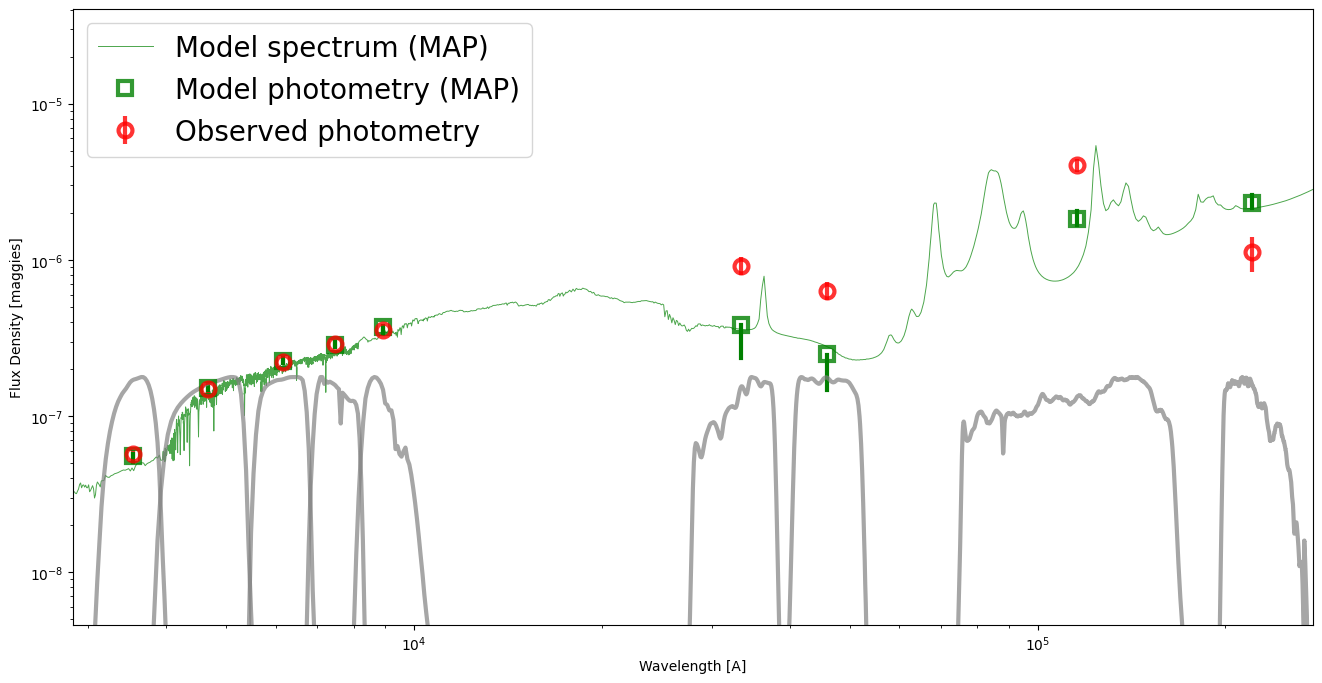

In [94]:
plt.figure(figsize=(16,8))

# plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
#        lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)


plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

for i in range(len(wphot)):
    plt.plot([wphot[i], wphot[i]], [fit_err_down[i], fit_err_up[i]], linewidth=3, color='green')



# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

# plt.ylim(1e-9, 1e-6)

***Answer:*** Freeing the redshift made the fit worse. There are now only 3 degrees of freedom, but my reduced chi-square is 5.9. My best fit redshift is not correct. It is 0.018, and the  $1\sigma$ confidence internal lies between 0.012 and 0.025. However, the real redshift is 0.041. Overall the fits on the corner plot are much worse, and there appears to be a degeneracy between mass and redshift 

In [95]:
def chisquare(obs, exp, sig):
    return np.sum((obs-exp)**2 / sig**2)

Xsq = chisquare(obs['maggies'], mphot_map, obs['maggies_unc'])

print(Xsq)


get_CI(res)

97.08642311296705


,param,best_fit,mean,-3sig,-2sig,-1sig,1sig,2sig,3sig
0,zred,0.017904,0.017941,0.006339,0.009673,0.012020,0.024825,0.038621,0.056792
1,mass,9.303092,9.427707,8.514542,8.737017,9.057337,9.648022,9.931449,10.147277
2,logzsol,0.183756,-0.627324,-1.997576,-1.967952,-1.750980,0.138701,0.185433,0.189782
3,dust2,0.673149,0.728594,0.511644,0.587166,0.647114,0.812225,0.908395,1.019875
4,tage,4.185453,7.610374,1.841804,2.602900,4.550165,11.101770,13.370137,13.777839
5,tau,1.383324,2.958221,0.324143,0.669245,1.252250,4.425993,7.309966,10.085715


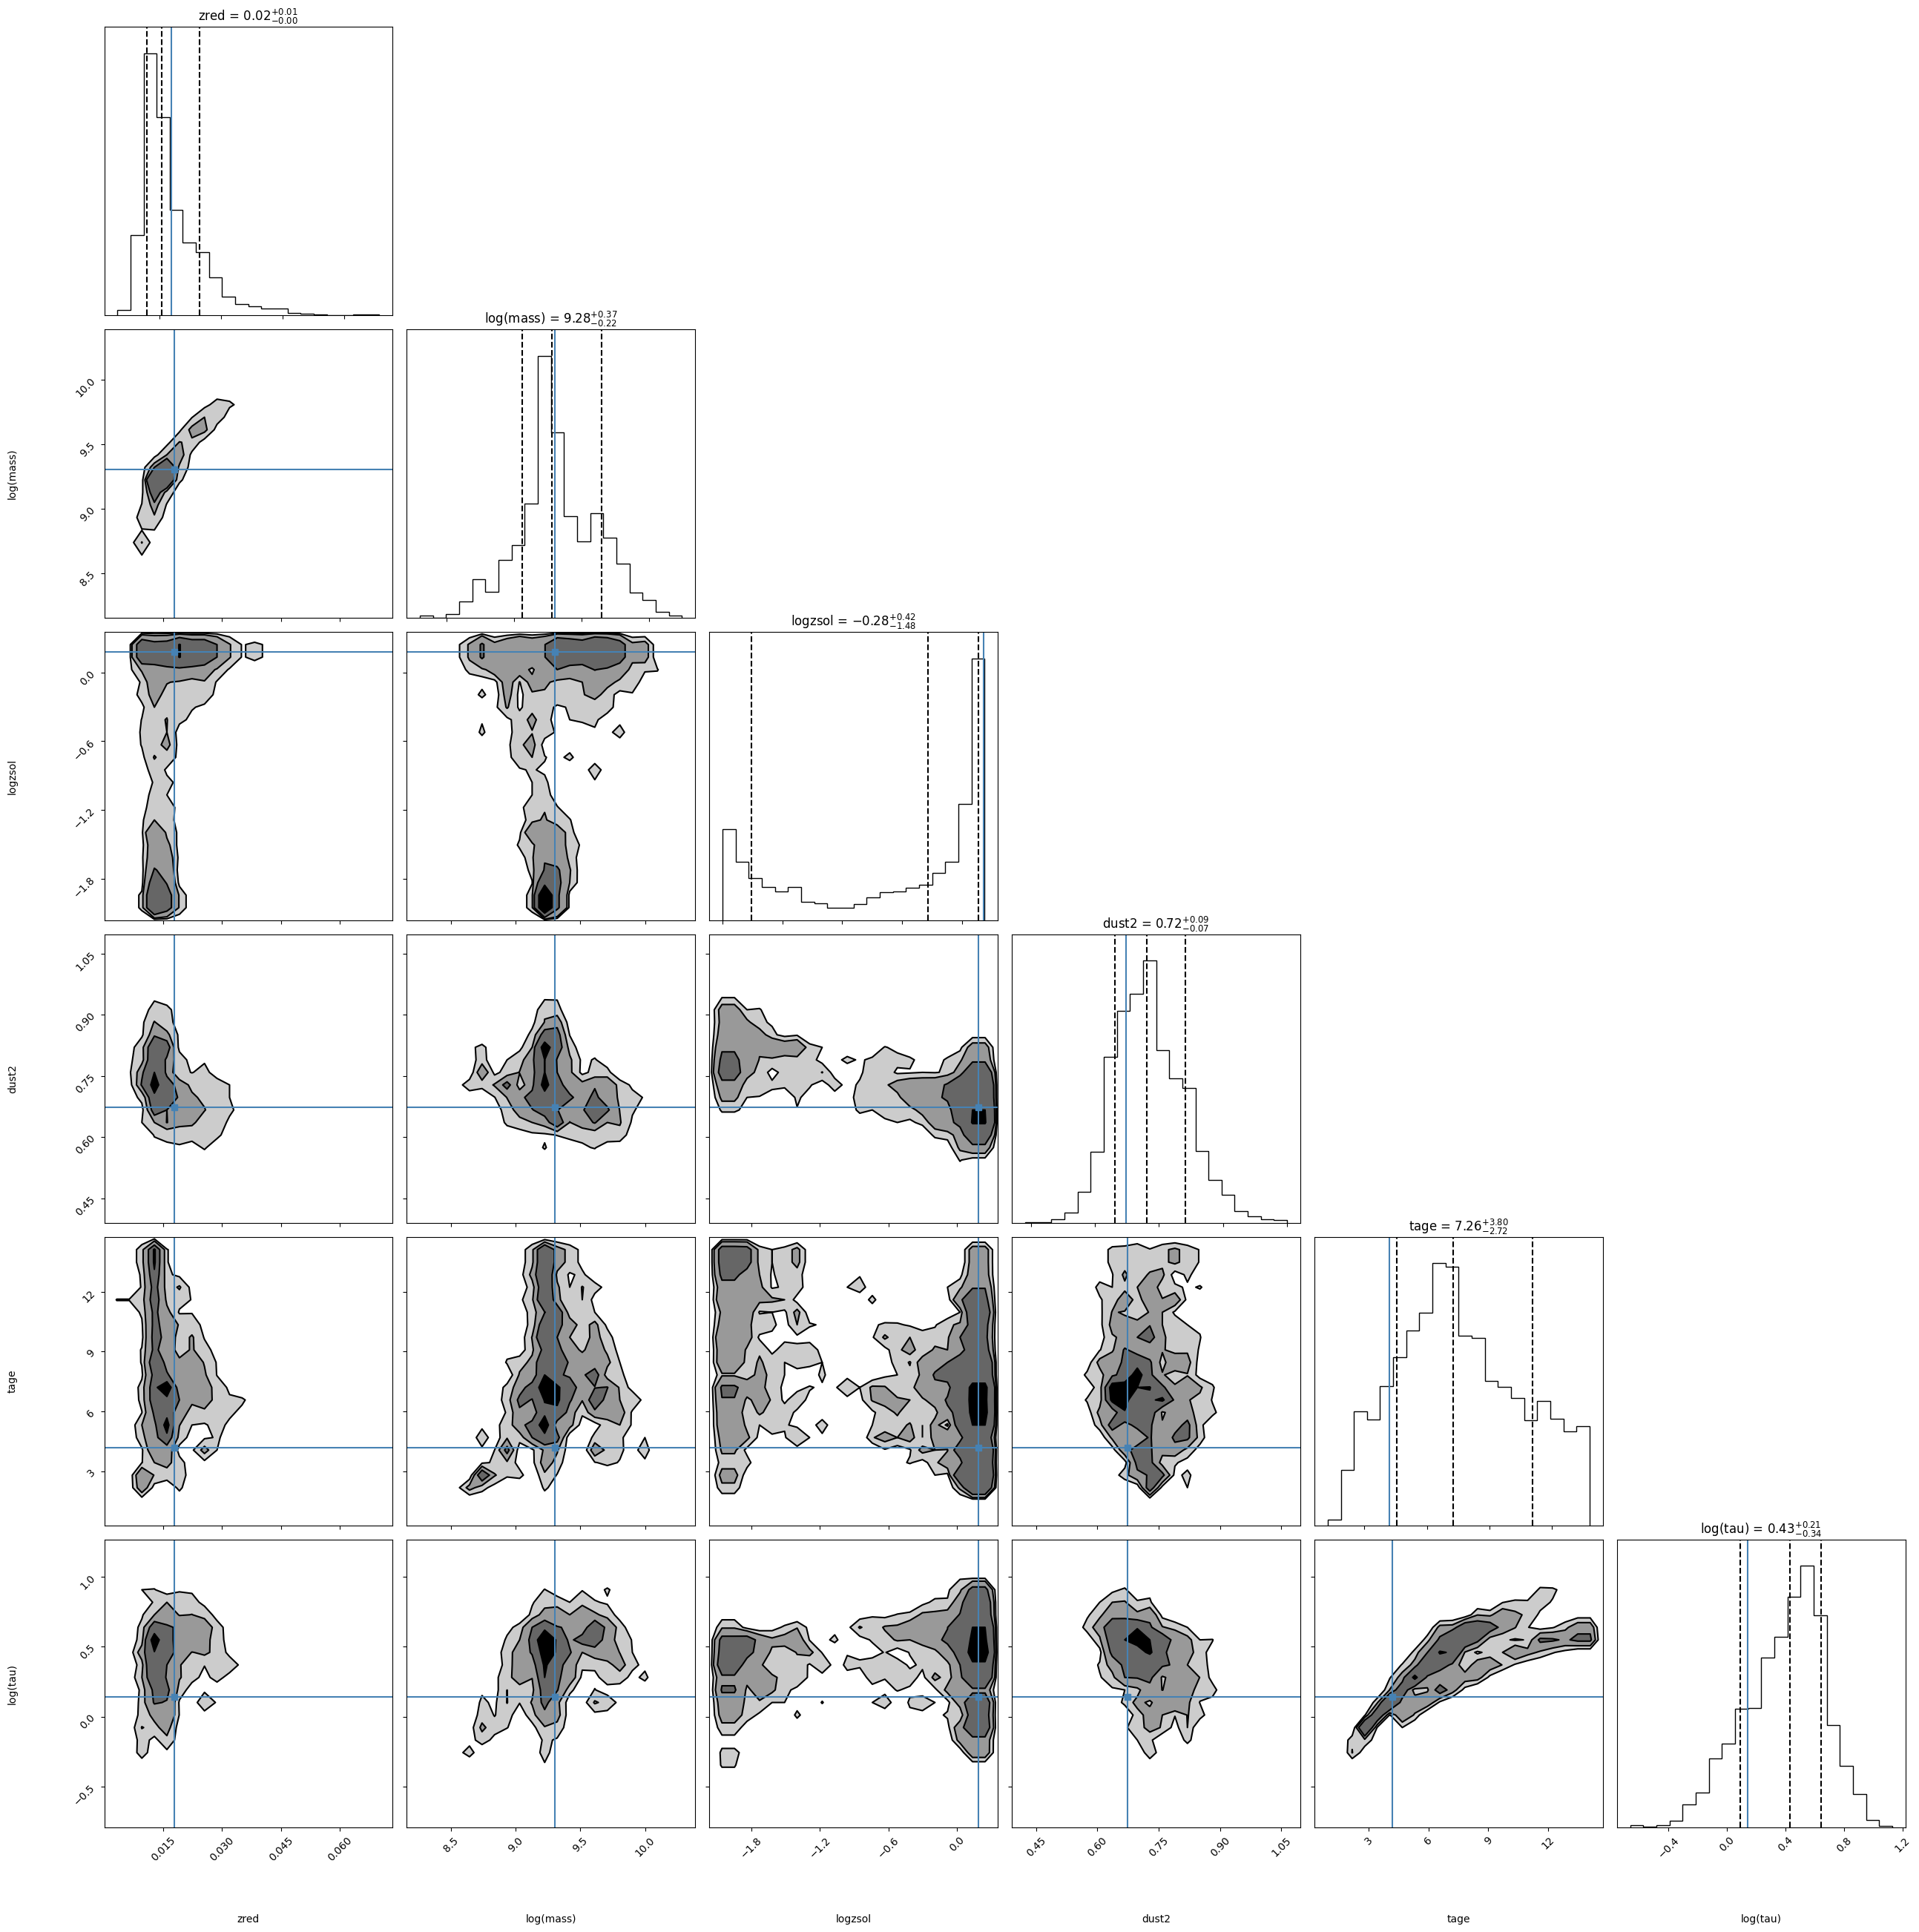

In [52]:
cornerfig = reader.subcorner(res, start=0, thin=thin, truths=theta_max, 
                             fig=plt.subplots(6,6,figsize=(27,27))[0])

# Section 2 

#### Step 1: Covariance

First lets look at the covariance of constrained parameters for one of your fits. Plot a corner plot of the prospector outputs, showing the 68% and 95% 2D contours. Remember, you can refer to the Prospector Example notebook on how to make a corner plot.

Are there any degeneracies between parameters in the fit? What does this mean?<br> How do the degeneracies change if we fix redshift or if we try to vary it?

***Answer:*** (Corner plots are in the above cells) When the redshift is fixed, there are no substantial degeneracies. When the redshift is allowed to vary, there is a degeneracy between $t_{age}$ and $\tau$. This implies that a galaxy that formed longer ago decays slower (larger $\tau$ ). In addition there is a degeneracy between stellar mass and redshift itself, whereby larger galaxies are at higher redshift and smaller galaxies are at lower redshift. Since higher redshift galaxies are further away, the limiting size to be able to detect or measure a galaxy at that redshift is higher than at lower redshifts.

#### Step 2: Covariance matrix

The covariance matrix describes the uncertainties of parameters, and their covariance with each other. Make the covariance matrix for one of your fits and plot it.

Looking at the contour plot, was this a reasonable thing to do? i.e. Is your covariance matrix a good descriptor of your posterior

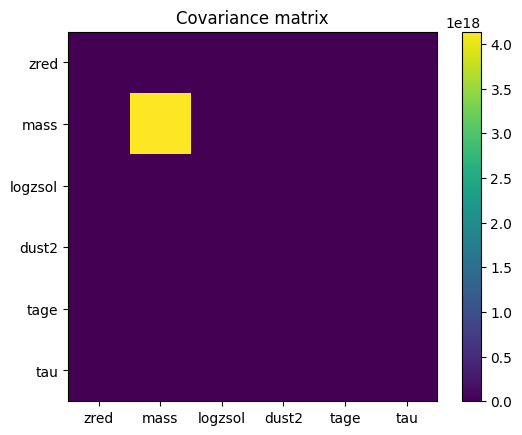

Text(0.5, 1.0, 'Correlation matrix')

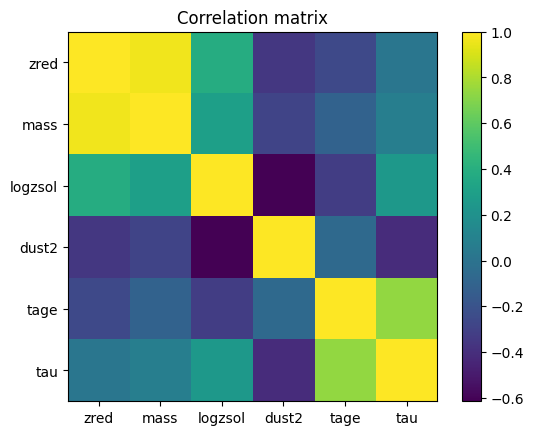

In [53]:
all_theta_flat.shape

cov = np.cov(all_theta_flat.T)
corr = np.corrcoef(all_theta_flat.T)

x = np.arange(6)
X, Y = np.meshgrid(x,x)
plt.imshow(cov)
plt.xticks(np.arange(6), res['theta_labels'])
plt.yticks(np.arange(6), res['theta_labels'])
plt.colorbar()
plt.title('Covariance matrix')
plt.show()

plt.imshow(corr)
plt.xticks(np.arange(6), res['theta_labels'])
plt.yticks(np.arange(6), res['theta_labels'])
plt.colorbar()
plt.title('Correlation matrix')

***Answer:*** The covariance matrix is not a particualrly useful thing here because the dynamic range of the parameters is a lot different from parameter to parameter. This makes the covariance matrix hard to interpret. The correlation matrix is useful, however, to see which two parameters may be correlated with each other. For example, there is a strong correlation between mass and redshift as we saw in the corner plots. However, doing this with contours on a corner plot shows the real structure of the correlation between parameters, which may be more informative.

#### Step 3: Covariance of magnitude errors

So far, Prospector has assumed the uncertainties in the magnitudes/fluxes are independent of each other. In practice this might not be true. For this excercise, assume the correlation between the flux in each band is X%.

Plot the covariance matrix, with and without the correlated errors.

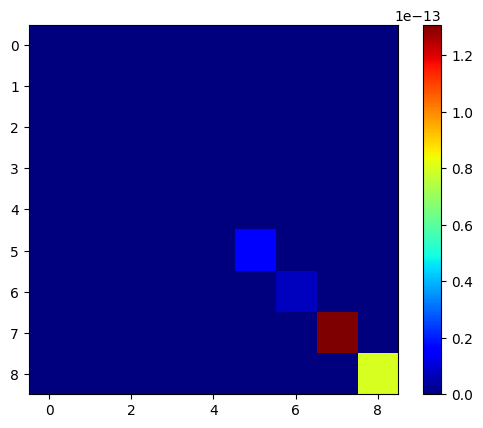

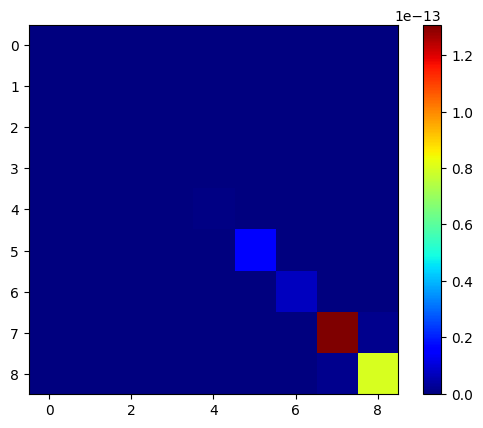

In [91]:
import matplotlib.colors as clr

band=obs['phot_wave']
photo=obs['maggies']
photo_err=obs['maggies_unc']

cov_photo_uncorr = np.zeros((len(photo), len(photo)))
for r in range(len(photo)):
    cov_photo_uncorr[r,r] = photo_err[r]**2

plt.imshow(cov_photo_uncorr, cmap='jet')
plt.colorbar()
plt.show()



cov_photo_corr = np.copy(cov_photo_uncorr)
for i in range(len(photo)):
    for j in range(len(photo)):
        if i == j:
            continue
        elif i < j:
            continue
        else:
            cor_per_i = np.random.random()*0.2
            cor_per_j = np.random.random()*0.2
            cor_sign = np.random.randint(2)
            if cor_sign == 0:
                err = photo_err[i]*photo_err[j]*cor_per_i*cor_per_j
            else:
                err = -1*photo_err[i]*photo_err[j]*cor_per_i*cor_per_j
        cov_photo_corr[i,j] = err
        cov_photo_corr[j,i] = err
        


plt.imshow(cov_photo_corr, cmap='jet')
plt.colorbar()


Re-compute the goodness of fit with the correlated errors. <br>
Did the goodness-of-fit get worse or better, why?

In [96]:
model = res['bestfit']['photometry']

cov_photo_corr_inv = np.linalg.inv(cov_photo_corr)

chi_sq = np.matmul(np.matmul(np.transpose(model-photo), cov_photo_corr_inv), (model-photo))

chi_sq

96.75638530164682

***Answer:*** My $\chi^2$ got slightly better. I think this makes sense because we have taken into account some correlation of the photometric data points, and that correlation actually exists.

# Section 3 

#### Estimating the uncertainties

For this section, we will use the output catalogs, since running prospector on all 800000 galaxies would be a waste of computing for this class.

Plot a histogram of a given measured quantity (stellar mass, redshift, etc). Choose the range and bin size appropriately so that we can see the full distribution.

61


<ErrorbarContainer object of 3 artists>

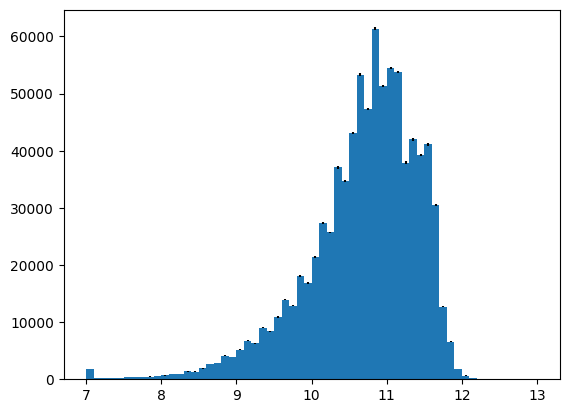

In [54]:
import numpy as np
import matplotlib.pyplot as plt
mstel_med = chang['lmass50_all']
mstel_med = mstel_med[mstel_med > 0]
size=0.1
bins = np.arange(np.min(mstel_med), np.max(mstel_med)+size, size)
print(len(bins))

hist, bin_edges = np.histogram(mstel_med, bins)

plt.bar(bin_edges[:-1] + size/2.0, hist, width=size)
plt.errorbar(bin_edges[:-1] + size/2.0, hist, yerr=np.sqrt(hist), color='k', fmt=' ')

There are a limited number of objects in each histogram bin. Add shot, or Poisson, noise to the histogram bars to show this. These will be your "analytic" error bars.

Now split the data into N subsets and compute the jackknife covarinace of the histogram bins.

* How does it compare to the analytic errors?
* Are the bins independent?
* What happens if you make N very large or very small?


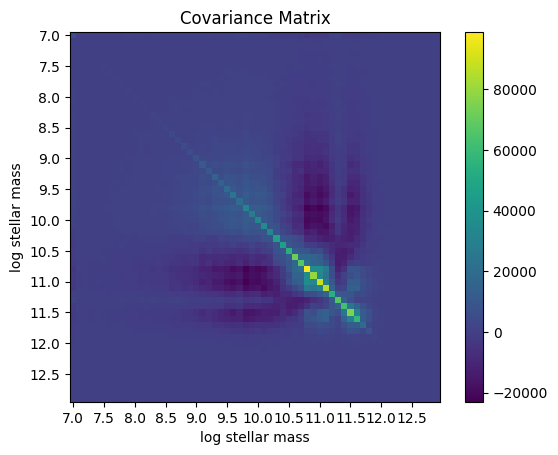

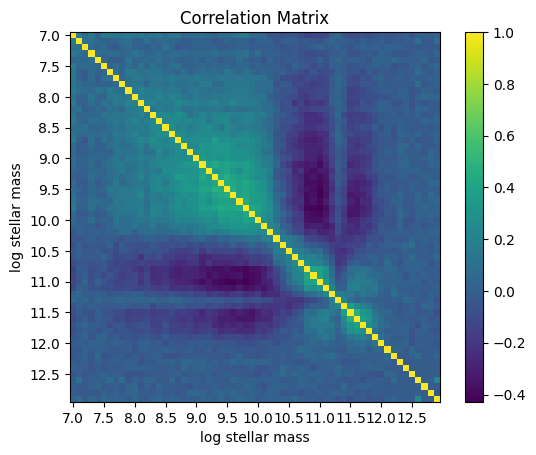

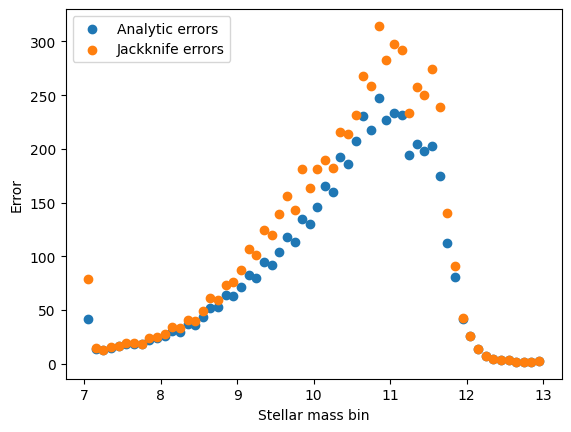

In [55]:
def jack(data, N_jack=200):
    all_samples = np.array_split(data, N_jack)
    # print('start', len(all_samples))
    all_hist = []
    for i in range(len(all_samples)):
        resample_ini = all_samples[:i] + all_samples[i+1:]

        resample = np.concatenate(resample_ini).ravel()

        hist, bin_edges = np.histogram(resample, bins)
        all_hist.append(hist)
    all_hist = np.array(all_hist)
    jack_cov = np.cov(all_hist.T)
    jack_corr = np.corrcoef(all_hist.T)
    return jack_cov, jack_corr


N_jack = 1000
jack_cov, jack_corr = jack(mstel_med, N_jack)

jack_cov = jack_cov*(N_jack-1)*(N_jack-1)/N_jack

jack_error = np.sqrt(np.diagonal(jack_cov))



plt.imshow(jack_cov)
plt.title('Covariance Matrix')
plt.colorbar()
bin_edges_plot = bin_edges[::5]
plt.xticks(range(0, len(bins)-1, 5), labels=[str(round(y,3)) for y in bin_edges_plot[:-1]])
plt.yticks(range(0, len(bins)-1, 5), labels=[str(round(y,3)) for y in bin_edges_plot[:-1]])
plt.xlabel('log stellar mass')
plt.ylabel('log stellar mass')
plt.show()

plt.imshow(jack_corr)
plt.title('Correlation Matrix')
plt.colorbar()
plt.xticks(range(0, len(bins)-1, 5), labels=[str(round(y,3)) for y in bin_edges_plot[:-1]])
plt.yticks(range(0, len(bins)-1, 5), labels=[str(round(y,3)) for y in bin_edges_plot[:-1]])
plt.xlabel('log stellar mass')
plt.ylabel('log stellar mass')
plt.show()

plt.scatter(bin_edges[:-1] + size/2.0, np.sqrt(hist), label='Analytic errors')
plt.scatter(bin_edges[:-1] + size/2.0, jack_error, label='Jackknife errors')
plt.xlabel('Stellar mass bin')
plt.ylabel('Error')
plt.legend()

***Answer:*** After removing any galaxies with no stellar masses, I split the sample into bins of 0.1dex in stellar mass. The analytic errors on the bins are are $\sqrt(N)$ where $N$ is the number of galaxies in each bin. This is simple Poisson noise. To jackknife the sample I tried a range of $N_{jk}$ values. I found that if $N_{jk}$ is too small, there are not enough jackknife resamples to get meaningful statistics on your jackknife procedure. On the other extreme end, if $N_{jk}$ is too large, i.e. approaching $N$, each jackknife iteration will not have a substantially different set of galaxies in it, which my bias the result. I chose $N_{jk}=1000$ to show here. I found that the jackknife errors (square root of the diagonal of the convariance matrix) are similar to the analytic errors, though typically a little bit larger. 
I have also shown the covariance and correlation matrices. As can be seen, the bins are not entirely independent from each other! On the correlation matrix, many of the off diagonal values are greater than 0.

Now repeat this excercise, replacing the histogram with a calculation of the mean stellar mass as a function of redshift (i.e. split the data into redshift bins, and compute the mean mass in each).

Use Jackknife to get the errors. How do these compare with the standard error of the mean?

[0.  0.1 0.2 0.3 0.4 0.5]
        Mean       SEM  Jack error 1  Jack error 2         N
0  10.163971  0.001210      0.004429      0.004429  354824.0
1  10.876066  0.000694      0.004045      0.004045  336052.0
2  11.258920  0.001623      0.007109      0.007109   69391.0
3  11.475822  0.001143      0.004441      0.004441   61230.0
4  11.612607  0.001399      0.003132      0.003132   30101.0


Text(0, 0.5, 'redshift')

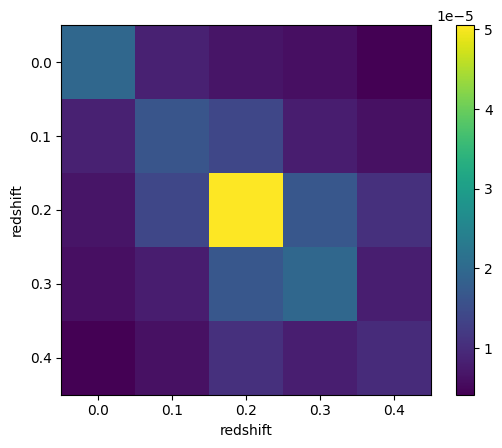

In [56]:
import pandas as pd

def jack(data, N_jack=2000):
    all_samples = np.array_split(data, N_jack)
    # print('start', len(all_samples))
    all_means = []
    for i in range(len(all_samples)):
        resample_ini = all_samples[:i] + all_samples[i+1:]
        resample = np.concatenate(resample_ini).ravel()
        jack_mean_i = np.mean(resample)
        all_means.append(jack_mean_i)

    all_means = np.array(all_means)
    jack_mean = np.mean(all_means)
    jack_error = np.sqrt((N_jack - 1)/N_jack * np.sum((all_means - jack_mean)**2))
    return jack_error

def jack2(data, N_jack=2000):

    all_things = []

    for bin in mstel_zbins:


        all_samples = np.array_split(bin, N_jack)
        # print('start', len(all_samples))
        all_means = []
        for i in range(len(all_samples)):
            resample_ini = all_samples[:i] + all_samples[i+1:]
            resample = np.concatenate(resample_ini).ravel()
            jack_mean_i = np.mean(resample)
            all_means.append(jack_mean_i)
        all_things.append(all_means)
    all_things = np.array(all_things)
    cov = np.cov(all_things)
    return cov


mstel_med = chang['lmass50_all']
z = chang_in['redshift']
cut1 = mstel_med > 0
z = z[cut1]
mstel_med = mstel_med[cut1 > 0]
cut2 = z > 0
z = z[cut2]
mstel_med = mstel_med[cut2 > 0]
cut3 = z < 0.5
z = z[cut3]
mstel_med = np.array(mstel_med[cut3 > 0], dtype=float)


z_bins = np.arange(0, 0.6, 0.1)
print((z_bins))


N_jack = 1000
cov = jack2(mstel_zbins, N_jack)*(N_jack - 1)*(N_jack-1)/N_jack


jack_err = np.sqrt(np.diagonal(cov))



make_table = []
mstel_zbins = [mstel_med[np.where((z > low) & (z <= high))] for low, high in zip(z_bins[:-1], z_bins[1:])]
for i in range(len(mstel_zbins)):
    bin = mstel_zbins[i]
    jack_error = jack(bin, N_jack)
    make_table.append([np.mean(bin), np.std(bin)/np.sqrt(len(bin)), jack_error, jack_err[i], len(bin)])

df = pd.DataFrame(np.array(make_table), columns=['Mean', 'SEM', 'Jack error 1', 'Jack error 2', 'N'])
print(df)
plt.imshow(cov)
plt.colorbar()
plt.xticks(range(len(z_bins)-1), labels=[str(round(y,3)) for y in z_bins[:-1]])
plt.yticks(range(len(z_bins)-1), labels=[str(round(y,3)) for y in z_bins[:-1]])
plt.xlabel('redshift')
plt.ylabel('redshift')



***Answer:*** To simplify this, I just did 5 redshift bins from 0 to 0.5, where $\Delta z = 0.1$ (this is the space where most of the galaxies live). All the statistics computer were also on the log of the stellar masses. The standard errors of the mean are quite small in each bin, since there are thousands of galaxies in each bin and the dynamic range of the stellar mass is only about 6 in log space. To jackknife the samples, I split each bin into 1000 resamples and computed the mean each time. To get the jackknife errors, I took the square root of the diagonal of the convariance matrix. I also calculated the convariance on each bin individually to see if this gives you the same values as the diagonals of the convariance matrix, which it does. The jackknife errors are a bit larger than the standard errors of the means, as expected. 